<a href="https://colab.research.google.com/github/anamika1302/CS-541-NER-SARK_NLP/blob/main/NER_Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training NER MODEL 2 on enitities :**
# **"Alcohol","Drug","Tobacco","LivingStatus","Employment" **


In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display



     |████████████████████████████████| 212.4 MB 74 kB/s 
     |████████████████████████████████| 142 kB 22.8 MB/s 
     |████████████████████████████████| 198 kB 61.1 MB/s 
     |████████████████████████████████| 95 kB 2.6 MB/s 
     |████████████████████████████████| 66 kB 4.6 MB/s 


In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

     |████████████████████████████████| 188 kB 2.8 MB/s 


In [ ]:
import sparknlp
import os
from sparknlp.training import CoNLL
spark = sparknlp.start(gpu = True) # for GPU training >> sparknlp.start(gpu = True)

from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark



Spark NLP version 3.4.2
Apache Spark version: 3.1.2


In [ ]:

with open('/content/drive/MyDrive/umass_ner/NER_MODEL_2/train_ner_model2.conll') as f:
    train_txt =f.read()

print (train_txt[:500])



-DOCSTART- -X- -X- O

Social NN NN O
History NN NN O
: NN NN O
Tob NNP NNP B-Tobacco
(-), NN NN O
EtOH NNP NNP B-Alcohol
- NN NN O
a NN NN O
glass NN NN O
of NN NN O
wine NN NN O
1-2x/month NN NN O
, NN NN O
IVDU NNP NNP B-Drug
(-), NN NN O
lives NNP NNP B-LivingStatus
with NN NN O
her NN NN O
husband NN NN O
and NN NN O
9yr NN NN O
old NN NN O
daughter NN NN O
, NN NN O
does NN NN O
not NN NN O
work NNP NNP B-Employment
outside NN NN O
of NN NN O
the NN NN O
home NN NN O
. NN NN O

SOCIAL NN NN


In [ ]:
#Loading training dataset

training_data = CoNLL().readDataset(spark, '/content/drive/MyDrive/umass_ner/NER_MODEL_2/train_ner_model2.conll')

training_data.show(3)



+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Social History : ...|[{document, 0, 15...|[{document, 0, 15...|[{token, 0, 5, So...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
|SOCIAL HISTORY : ...|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 5, SO...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
|Social History : ...|[{document, 0, 12...|[{document, 0, 12...|[{token, 0, 5, So...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
training_data.count()

1316

In [ ]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).limit(100).show()

+----------+---+--------------+
|     token|pos|     ner_label|
+----------+---+--------------+
|    Social| NN|             O|
|   History| NN|             O|
|         :| NN|             O|
|       Tob|NNP|     B-Tobacco|
|      (-),| NN|             O|
|      EtOH|NNP|     B-Alcohol|
|         -| NN|             O|
|         a| NN|             O|
|     glass| NN|             O|
|        of| NN|             O|
|      wine| NN|             O|
|1-2x/month| NN|             O|
|         ,| NN|             O|
|      IVDU|NNP|        B-Drug|
|      (-),| NN|             O|
|     lives|NNP|B-LivingStatus|
|      with| NN|             O|
|       her| NN|             O|
|   husband| NN|             O|
|       and| NN|             O|
+----------+---+--------------+
only showing top 20 rows



In [ ]:
training_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+--------------+-----+
|ground_truth  |count|
+--------------+-----+
|O             |62105|
|B-Alcohol     |1293 |
|B-Tobacco     |1227 |
|B-Drug        |986  |
|B-Employment  |981  |
|B-LivingStatus|959  |
|I-Drug        |930  |
|I-Employment  |723  |
|I-Alcohol     |444  |
|I-Tobacco     |402  |
|I-LivingStatus|110  |
+--------------+-----+



In [ ]:
test_data = CoNLL().readDataset(spark, '/content/drive/MyDrive/umass_ner/NER_MODEL_2/testF_ner_model2.conll')

test_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)


+--------------+-----+
|ground_truth  |count|
+--------------+-----+
|O             |5954 |
|B-Alcohol     |162  |
|B-Tobacco     |154  |
|B-LivingStatus|116  |
|I-Employment  |103  |
|B-Drug        |101  |
|I-Drug        |98   |
|B-Employment  |90   |
|I-Tobacco     |59   |
|I-Alcohol     |53   |
|I-LivingStatus|3    |
+--------------+-----+



In [ ]:
import pyspark.sql.functions as F

test_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).limit(100).show()

+---------+---+--------------+
|    token|pos|     ner_label|
+---------+---+--------------+
|   SOCIAL| NN|             O|
|  HISTORY| NN|             O|
|        :| NN|             O|
|    Lives|NNP|B-LivingStatus|
|     with| NN|             O|
|      his| NN|             O|
|   caring| NN|             O|
|      and| NN|             O|
|  devoted| NN|             O|
|  parents| NN|             O|
|       at| NN|             O|
|     home| NN|             O|
|        .| NN|             O|
|   Enjoys| NN|             O|
|   movies| NN|             O|
|      and| NN|             O|
|computers| NN|             O|
|        .| NN|             O|
|       No| NN|             O|
|  history| NN|             O|
+---------+---+--------------+
only showing top 20 rows



In [ ]:
bert_embedding = BertEmbeddings.pretrained('bert_base_cased', 'en')\
   .setInputCols(["sentence",'token'])\
   .setOutputCol("bert_embeddings")\
   .setCaseSensitive(True)

bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]


In [ ]:
bert_embedding.transform(test_data).write.parquet('/content/drive/MyDrive/umass_ner/NER_MODEL_2/testF_data_ner_model2_bert_embedding.parquet')

In [ ]:
# !rm -r /content/drive/MyDrive/umass_ner/NER_MODEL_1/test_data_bert_embedding.parquet

In [ ]:
# !mkdir /root/ner_logs_model1

In [ ]:
# !rm -r /root/ner_logs_model1/

In [ ]:
nerTagger = NerDLApproach()\
      .setInputCols(["sentence", "token", "bert_embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(20)\
      .setLr(0.0002)\
      .setBatchSize(16)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setUseBestModel(True)\
      .setTestDataset('/content/drive/MyDrive/umass_ner/NER_MODEL_2/testF_data_ner_model2_bert_embedding.parquet')\
      .setOutputLogsPath('./ner_dl_logs_model2')# if not set, logs will be written to ~/annotator_logs
 #    .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
 #    .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
# do hyperparameter by tuning the params above (max epoch, LR, dropout etc.) to get better results
ner_pipeline = Pipeline(stages=[
      bert_embedding,
      nerTagger
 ])



In [ ]:
ner_model = ner_pipeline.fit(training_data)

In [ ]:
!cd /content/ner_dl_logs_model2 && ls -lt

total 24
-rw-r--r-- 1 root root 17919 Apr 27 20:09 NerDLApproach_7a0ac9f52b9b.log


In [ ]:
!cat /content/ner_dl_logs_model2/NerDLApproach_7a0ac9f52b9b.log

Name of the selected graph: ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 20 - lr: 2.0E-4 - batch size: 16 - labels: 11 - chars: 89 - training examples: 1316


Epoch 1/20 started, lr: 2.0E-4, dataset size: 1316


Epoch 1/20 - 28.16s - loss: 3267.386 - batches: 85
Quality on test dataset: 
time to finish evaluation: 1.07s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-Drug	 5	 2	 44	 0.71428573	 0.10204082	 0.17857143
I-Alcohol	 0	 0	 36	 0.0	 0.0	 0.0
B-Tobacco	 17	 8	 50	 0.68	 0.25373134	 0.36956522
B-Alcohol	 16	 3	 58	 0.84210527	 0.21621622	 0.34408605
I-LivingStatus	 0	 0	 1	 0.0	 0.0	 0.0
B-LivingStatus	 14	 3	 39	 0.8235294	 0.26415095	 0.4
I-Tobacco	 0	 0	 27	 0.0	 0.0	 0.0
B-Employment	 0	 0	 44	 0.0	 0.0	 0.0
I-Drug	 15	 4	 38	 0.7894737	 0.28301886	 0.41666666
I-Employment	 0	 0	 51	 0.0	 0.0	 0.0
tp: 67 fp: 20 fn: 388 labels: 10
Macro-average	 prec: 0.38493943, rec: 0.11191581, f1: 0.17341393
Micro-average	 prec: 0.77011496, rec: 0.14725275, f1: 0.24723248


Epoch 2/

In [ ]:
pred_df = ner_model.stages[1].transform(bert_embedding.transform(test_data))
# pred_df = ner_model.stages[1].transform(test_data)

NameError: ignored

In [ ]:
import pyspark.sql.functions as F

pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                          pred_df.label.result,
                                          pred_df.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).toPandas()

,token,ground_truth,prediction
0,SOCIAL,O,O
1,HISTORY,O,O
2,:,O,O
3,Lives,B-LivingStatus,B-LivingStatus
4,with,O,O
...,...,...,...
6888,father,O,O
6889,of,O,O
6890,one,O,O
6891,son,O,O


In [ ]:
import pyspark.sql.functions as F

pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                          pred_df.label.result,
                                          pred_df.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).show(truncate=False)



+---------+--------------+--------------+
|token    |ground_truth  |prediction    |
+---------+--------------+--------------+
|SOCIAL   |O             |O             |
|HISTORY  |O             |O             |
|:        |O             |O             |
|Lives    |B-LivingStatus|B-LivingStatus|
|with     |O             |O             |
|his      |O             |O             |
|caring   |O             |O             |
|and      |O             |O             |
|devoted  |O             |O             |
|parents  |O             |O             |
|at       |O             |O             |
|home     |O             |O             |
|.        |O             |O             |
|Enjoys   |O             |O             |
|movies   |O             |O             |
|and      |O             |O             |
|computers|O             |O             |
|.        |O             |O             |
|No       |O             |O             |
|history  |O             |O             |
+---------+--------------+--------

In [ ]:
from sklearn.metrics import classification_report

preds_df_analysis = pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                                     pred_df.label.result,
                                                     pred_df.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df_analysis['ground_truth'], preds_df_analysis['prediction']))



                precision    recall  f1-score   support

     B-Alcohol       0.77      0.83      0.80       162
        B-Drug       0.90      0.82      0.86       101
  B-Employment       0.81      0.69      0.74        90
B-LivingStatus       0.97      0.75      0.84       116
     B-Tobacco       0.72      0.77      0.75       154
     I-Alcohol       0.88      0.68      0.77        53
        I-Drug       0.90      0.87      0.89        98
  I-Employment       0.82      0.70      0.75       103
I-LivingStatus       0.00      0.00      0.00         3
     I-Tobacco       0.78      0.54      0.64        59
             O       0.97      0.98      0.98      5954

      accuracy                           0.95      6893
     macro avg       0.77      0.69      0.73      6893
  weighted avg       0.95      0.95      0.95      6893



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ner_model.stages[1].write().overwrite().save('/content/drive/MyDrive/umass_ner/model_ner_dl_2')

In [ ]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py

import conll_eval

metrics = conll_eval.evaluate(preds_df_analysis['ground_truth'].values, preds_df_analysis['prediction'].values)


import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])



processed 6893 tokens with 623 phrases; found: 627 phrases; correct: 466.
accuracy:  75.61%; (non-O)
accuracy:  95.29%; precision:  74.32%; recall:  74.80%; FB1:  74.56
          Alcohol: precision:  72.73%; recall:  79.01%; FB1:  75.74  176
             Drug: precision:  82.83%; recall:  81.19%; FB1:  82.00  99
       Employment: precision:  60.87%; recall:  62.22%; FB1:  61.54  92
     LivingStatus: precision:  95.56%; recall:  74.14%; FB1:  83.50  90
          Tobacco: precision:  67.06%; recall:  74.03%; FB1:  70.37  170


,entity,precision,recall,f1,support
0,Alcohol,72.727273,79.012346,75.739645,176
1,Drug,82.828283,81.188119,82.000000,99
2,Employment,60.869565,62.222222,61.538462,92
3,LivingStatus,95.555556,74.137931,83.495146,90
4,Tobacco,67.058824,74.025974,70.370370,170


In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py


In [ ]:
import ner_log_parser

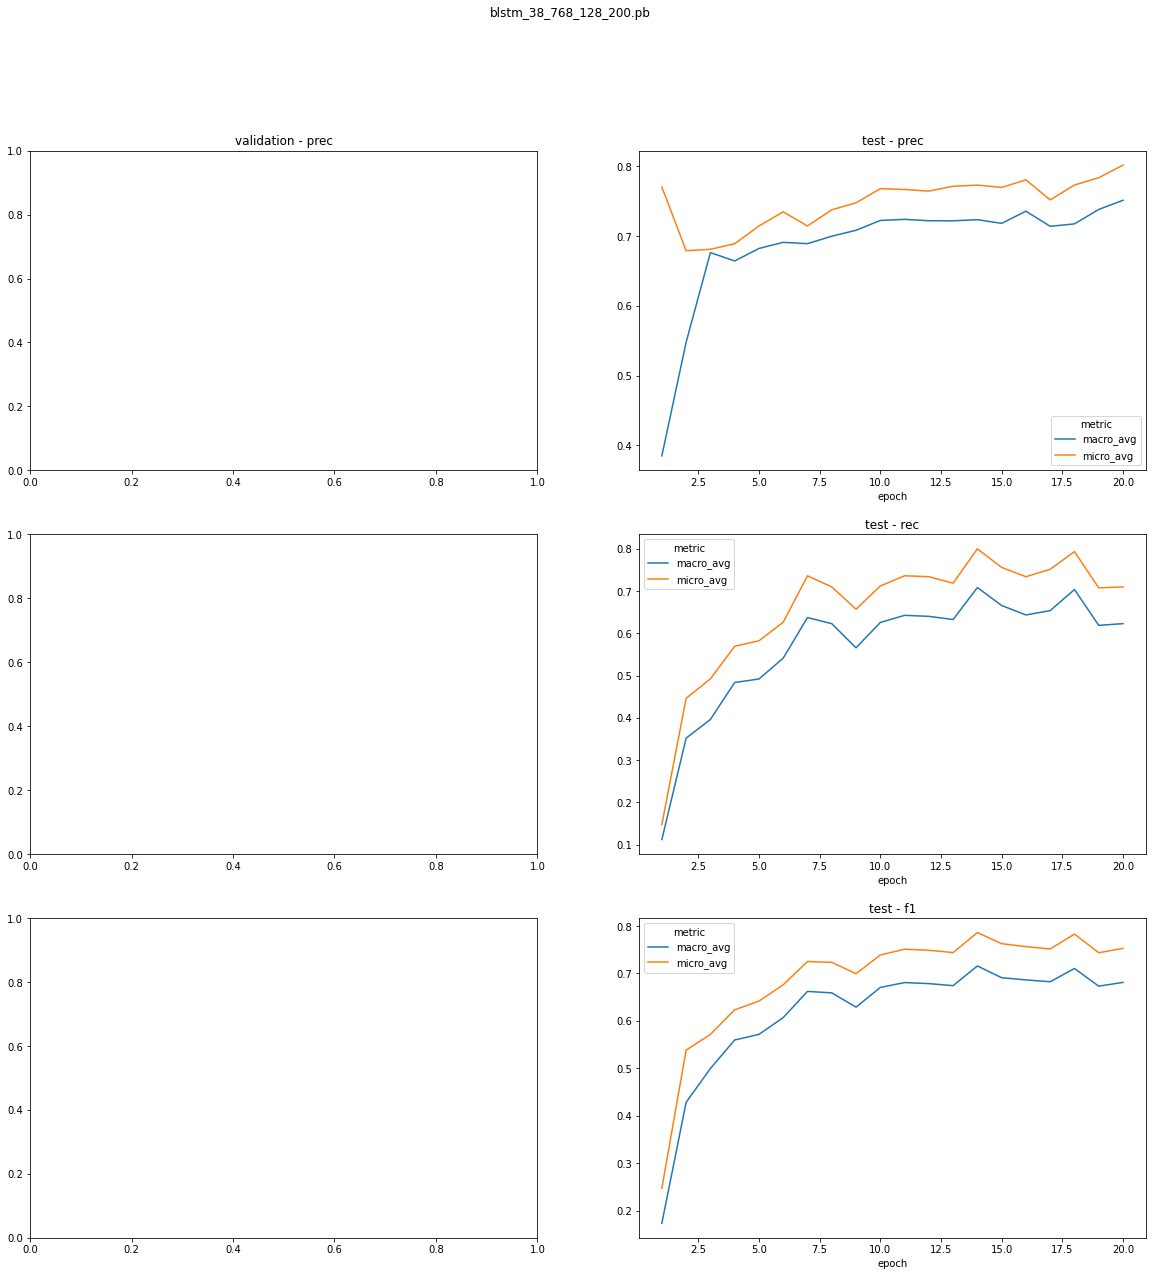

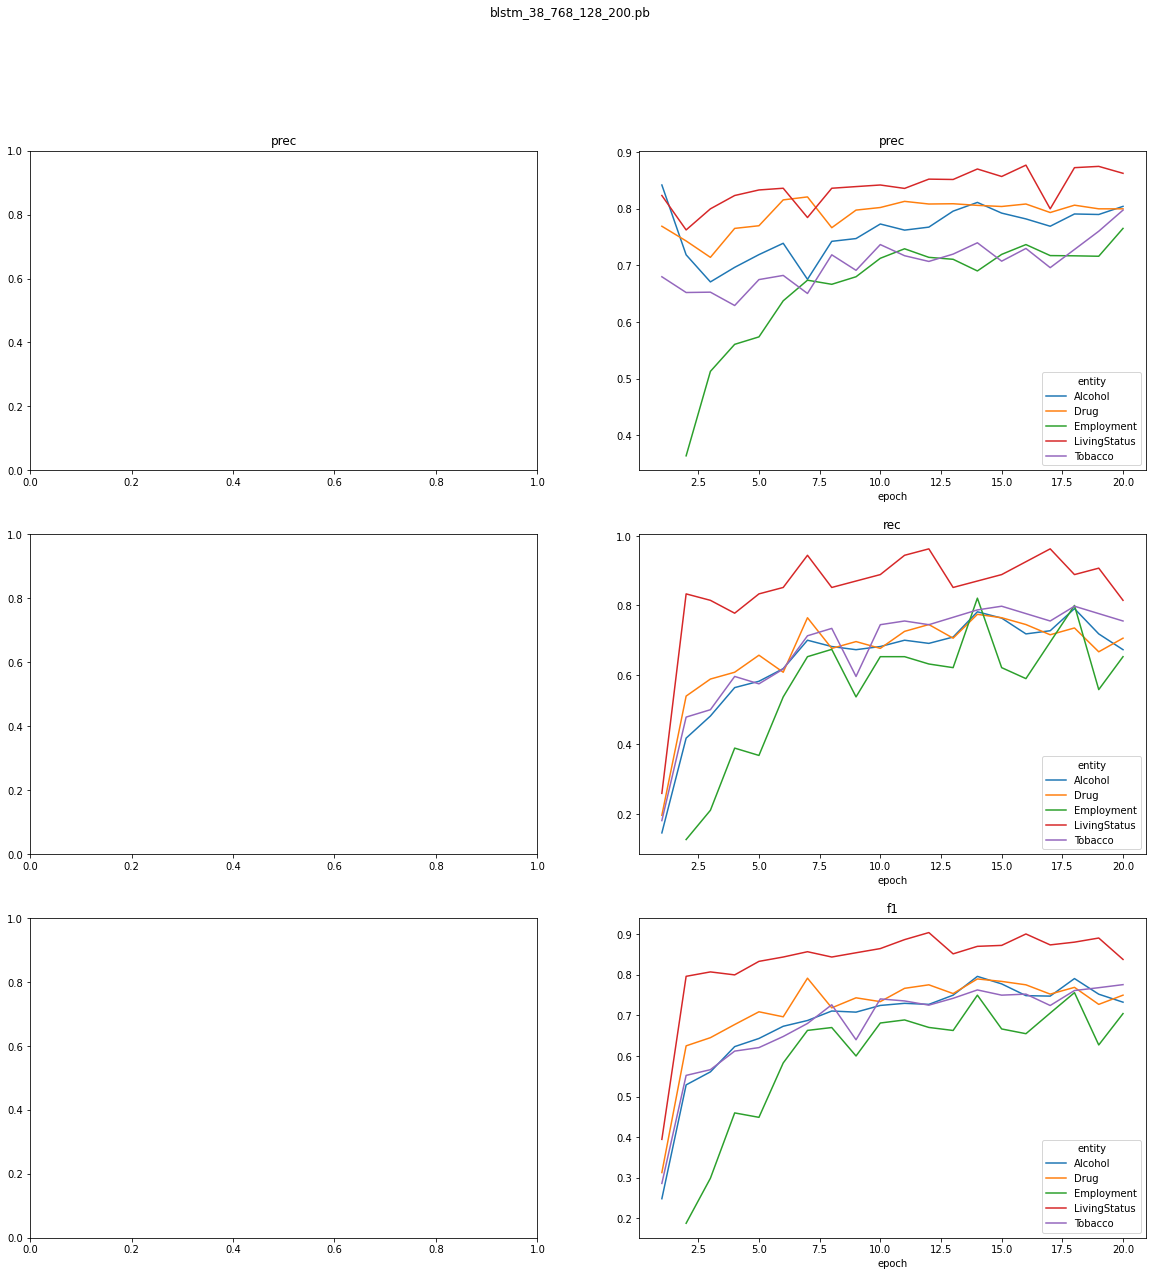

In [ ]:
ner_log_parser.get_charts('/content/ner_dl_logs_model2/NerDLApproach_7a0ac9f52b9b.log')

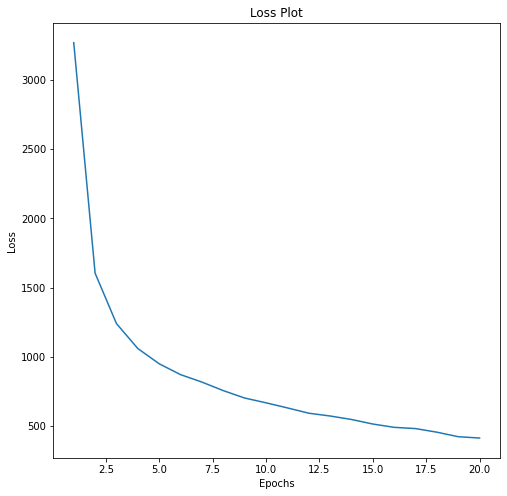

In [ ]:
ner_log_parser.loss_plot('/content/ner_dl_logs_model2/NerDLApproach_7a0ac9f52b9b.log')

In [ ]:


document = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')

token = Tokenizer()\
        .setInputCols(['sentence'])\
        .setOutputCol('token')

bert_embedding = BertEmbeddings.pretrained('bert_base_cased', 'en')\
   .setInputCols(["sentence",'token'])\
   .setOutputCol("bert_embeddings")\
   .setCaseSensitive(True)
  
# load trained model
loaded_ner_model = NerDLModel.load("/content/drive/MyDrive/umass_ner_old/model_ner_dl_2")\
        .setInputCols(["sentence", "token", "bert_embeddings"])\
        .setOutputCol("ner")

converter = NerConverter()\
        .setInputCols(["document", "token", "ner"])\
        .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages = [
        document,
        sentence,
        token,
        bert_embedding,
        loaded_ner_model,
        converter
])



bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]


In [ ]:

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)



In [ ]:
pred_df= prediction_model.transform(test_data)

In [ ]:


from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)



In [ ]:
text = """Social History:
Tob (-), EtOH - a glass of wine 1-2x/month, IVDU (-), lives with
her husband and 9yr old daughter, does not work outside of the
home."""

In [ ]:


import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df



,sent_id,token,start,end,ner
0,0,Social,0,5,O
1,0,History,7,13,O
2,0,:,14,14,O
3,0,Tob,16,18,B-Tobacco
4,0,"(-),",20,23,O
5,0,EtOH,25,28,B-Alcohol
6,0,-,30,30,O
7,0,a,32,32,O
8,0,glass,34,38,O
9,0,of,40,41,O


In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(result[0], label_col='ner_span', document_col='document', save_path="display_result.html")

In [ ]:
Social History: Tob, EtOH - a glass of wine 1-2x/month, IVDU lives with
her husband and 9yr old daughter, does not work outside of the home